# Задание

Используя заготовку кода в нотбуке из практики по Pytorch допишите самостоятельно CNN нейронную сеть и обучите ее на данных mnist.


> Обратите внимание, <br> что при использовании categorical cross entrophy функции потерь Вам не нужно использовать активацию softmax в последнем слое.


## Import

In [1]:
from numpy import vstack
from numpy import argmax
from pandas import read_csv
import torch
from torch import Tensor
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## MNIST 0-9 CNN

In [2]:
class CNN(Module):
    def __init__(self, n_channels):
        super(CNN, self).__init__()

        # input to first hidden layer
        self.hidden1 = Conv2d(n_channels, 32, (3,3)) # 32,26,26,32
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()

        # first pooling layer
        self.pool1 = MaxPool2d((2,2), stride=(2,2)) #32, 13,13,32

        # second hidden layer
        self.hidden2 = Conv2d(32, 32, (3,3)) # 32,11,11,32
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()

        # second pooling layer
        self.pool2 = MaxPool2d((2,2), stride=(2,2)) # 32,5,5,32

        # fully connected layer
        self.hidden3 = Linear(5*5*32, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()

        # output layer
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)
 
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)

        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)

        # flatten
        X = X.view(-1, 4*4*50)

        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        X = self.act4(X)
        return X

## Utils

In [3]:
def prepare_data(path):
    trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    train = MNIST(path, train=True, download=True, transform=trans)
    test = MNIST(path, train=False, download=True, transform=trans)
    train_dl = DataLoader(train, batch_size=64, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

In [4]:
def train_model(train_dl, model):
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(10):
        for i, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()

In [5]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        yhat = model(inputs)
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        yhat = argmax(yhat, axis=1)
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    return acc

In [6]:
def predict(row, model):
  row = Tensor([row]).float()
  yhat = model(row)
  yhat = yhat.detach().numpy()
  return yhat

## Подготовка данных

In [7]:
path = '~/.torch/datasets/mnist'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset),len(test_dl.dataset))

60000 10000


## Обучение

In [27]:
model = CNN(1)
train_model(train_dl, model)
acc = evaluate_model(test_dl, model)

In [28]:
print(f'Accuracy: {acc}')

Accuracy: 0.9857


## Проверка модели

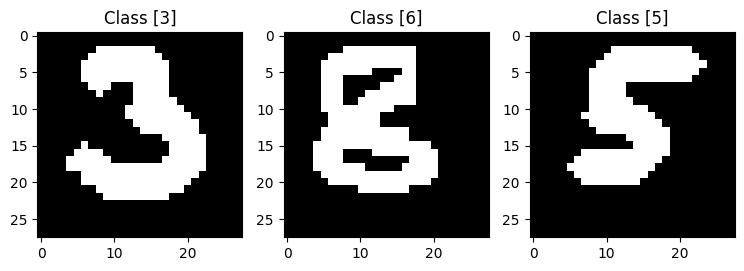

In [29]:
plt.rcParams['figure.figsize'] = (9,3) 

for i in range(3):
    # считывание bmp рисунков
    pic = Image.open(f"draw{i}.bmp")
    row = np.array(pic.getdata()).reshape(28, 28)
    
    # предикт
    yhat = predict(row, model)
    yhat = np.argmax(yhat, axis=1)

    # плот
    plt.subplot(1,3,i+1)
    plt.imshow(row, cmap='gray', interpolation='none')
    plt.title(f"Class {yhat}")